# 1. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Stting up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

# Seting pandas to display all columns - crucial for wide datasets
pd.set_option('display.max_columns', None)

print("Environment Setup Complete.")

Environment Setup Complete.


# 2. Load Data

In [2]:
train_path = '/kaggle/input/playground-series-s6e1/train.csv'
test_path = '/kaggle/input/playground-series-s6e1/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")

Train Shape: (630000, 13)
Test Shape:  (270000, 12)


# 3. Structure Check

In [3]:
display(train_df.head(10))

id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   
5   5   24    male    b.com         5.04              85.1             yes   
6   6   20    male     b.sc         4.28              87.0              no   
7   7   22  female       ba         4.19              44.9             yes   
8   8   22   other    b.com         1.06              98.3             yes   
9   9   18    male      bba         3.44              80.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6          good     self-study            high            easy   
5          9.4       average  online videos          medium        moderate   
6          9.1       average          mixed            high        moderate   
7          8.8          good     self-study            high            hard   
8          5.0          poor          mixed             low        moderate   
9          6.2          good    group study          medium            easy   

   exam_score  
0        78.3  
1        46.7  
2        99.0  
3        63.9  
4       100.0  
5        70.1  
6        63.4  
7        76.8  
8        46.7  
9        58.2

In [4]:
dupes = train_df.duplicated().sum()
print(f"\nDuplicate Rows: {dupes}")

missing = train_df.isnull().sum().sum()
print(f"Total Missing Values: {missing}")

if train_df['id'].nunique() == len(train_df):
    print("ID column is unique (Good).")
else:
    print("WARNING: ID column has duplicates!")


Duplicate Rows: 0
Total Missing Values: 0
ID column is unique (Good).


# 4. EDA (Exploratory Data Analysis)

## 4.1. Target Analysis (The "Normality" Check)

### a. Distribution Plot with KDE

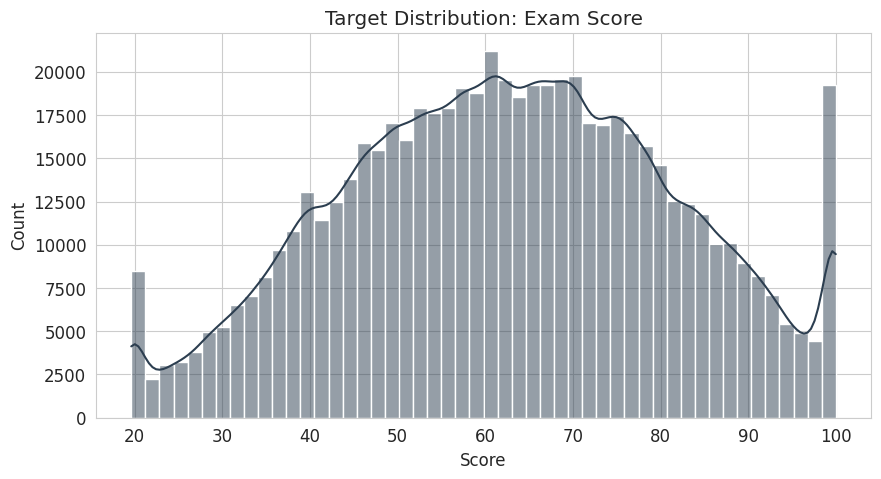

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(train_df['exam_score'], kde=True, color='#2c3e50', bins=50)
plt.title('Target Distribution: Exam Score')
plt.xlabel('Score')
plt.show()

### b. Statistical Metrics

In [6]:
skew = train_df['exam_score'].skew()
kurt = train_df['exam_score'].kurt()
print(f"Skewness: {skew:.4f} (Close to 0 is Normal)")
print(f"Kurtosis: {kurt:.4f} (Positive = Peaked, Negative = Flat)")

Skewness: -0.0483 (Close to 0 is Normal)
Kurtosis: -0.6190 (Positive = Peaked, Negative = Flat)


### c. Quantization Check

In [7]:
unique_vals = train_df['exam_score'].nunique()
print(f"Unique Target Values: {unique_vals}")
if unique_vals < 200:
    print("Insight: Target appears discrete/quantized.")
else:
    print("Insight: Target appears continuous.")

Unique Target Values: 805
Insight: Target appears continuous.


## 4.2. Adversarial Validation (Drift Check)

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

adv_train = train_df.drop('exam_score', axis=1).copy()
adv_test = test_df.copy()

adv_train['is_test'] = 0
adv_test['is_test'] = 1

adv_df = pd.concat([adv_train, adv_test], axis=0).reset_index(drop=True)
adv_df = adv_df.drop('id', axis=1)

for col in adv_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    adv_df[col] = le.fit_transform(adv_df[col].astype(str))

X = adv_df.drop('is_test', axis=1)
y = adv_df['is_test']

model = XGBClassifier(n_estimators=50, max_depth=4, learning_rate=0.1, random_state=42, tree_method='hist')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

aucs = []
for train_idx, val_idx in cv.split(X, y):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    val_preds = model.predict_proba(X.iloc[val_idx])[:, 1]
    aucs.append(roc_auc_score(y.iloc[val_idx], val_preds))

print(f"Adversarial Validation AUC: {np.mean(aucs):.4f}")

Adversarial Validation AUC: 0.4997


* **AUC ~ 0.50: Perfect, means the Train and Test sets are statistically identical**

## 4.3. Bivariate EDA (Diminishing Returns)

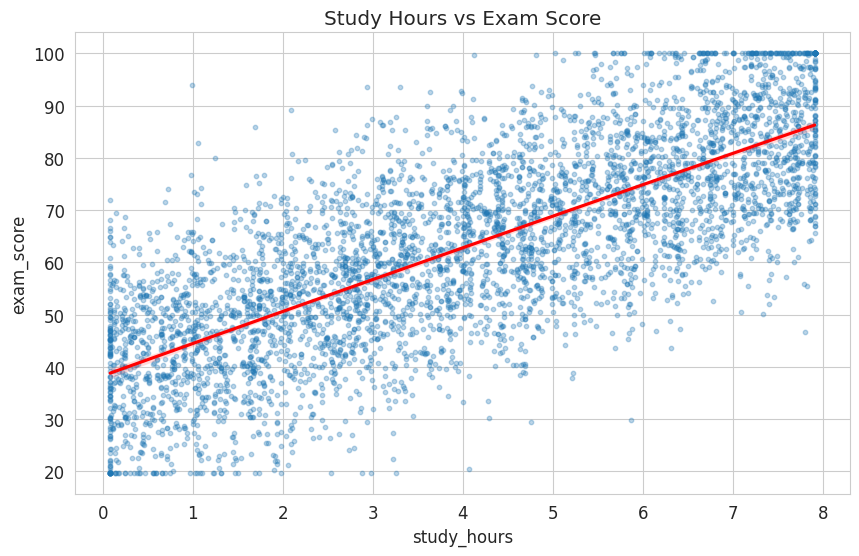

In [9]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=train_df.sample(5000),
    x='study_hours',
    y='exam_score',
    order=2,
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.3, 's': 10}
)
plt.title('Study Hours vs Exam Score')
plt.show()

* **Here relationship is not perfectly linear it exhibits a slight diminishing returns pattern.**

###  Column Columns

In [10]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Available Categorical Columns:", cat_cols)

print("\nAll Columns:", train_df.columns.tolist())

Available Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']

All Columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']


## 4.4. Multivariate EDA (Interaction Analysis)

Plotting interaction using feature: gender


<Figure size 1200x600 with 0 Axes>

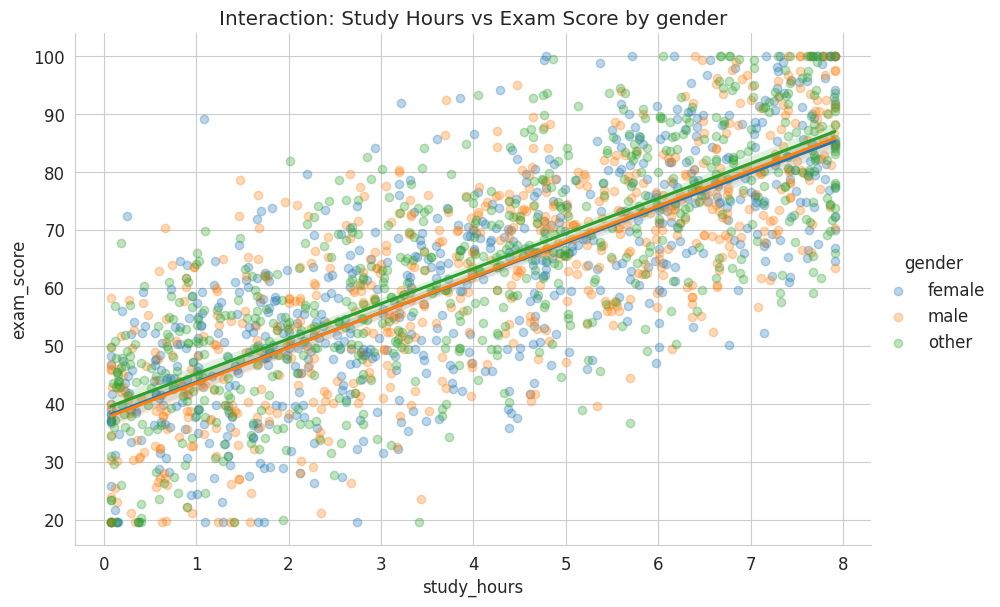

In [11]:
valid_hue = train_df.select_dtypes(include=['object']).columns[0] 
print(f"Plotting interaction using feature: {valid_hue}")

plt.figure(figsize=(12, 6))
sns.lmplot(
    data=train_df.sample(2000), 
    x='study_hours', 
    y='exam_score', 
    hue=valid_hue,
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3}
)
plt.title(f'Interaction: Study Hours vs Exam Score by {valid_hue}')
plt.show()

<Figure size 1000x600 with 0 Axes>

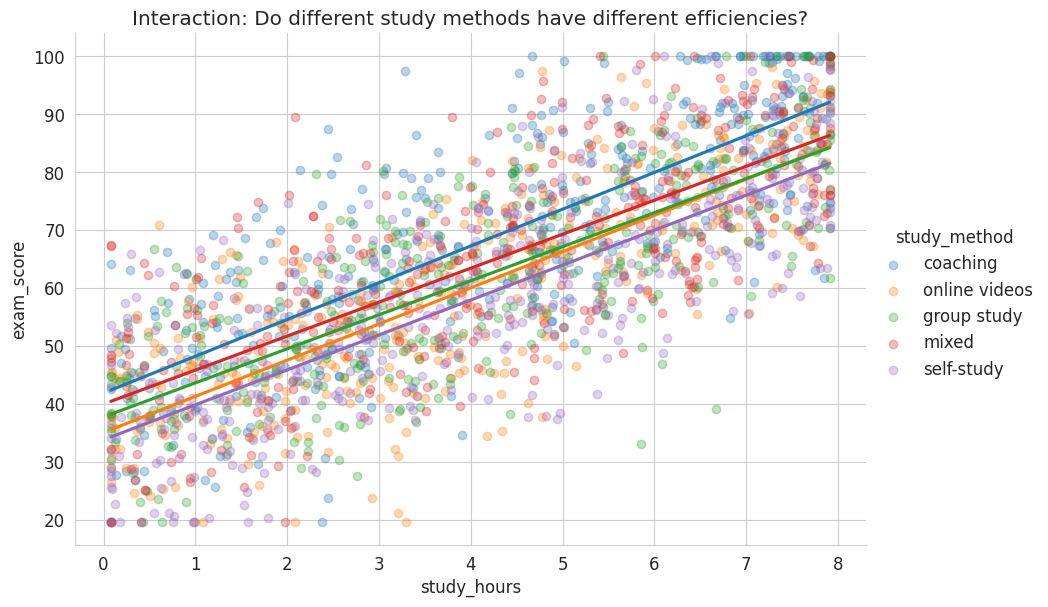

In [12]:
from sklearn.feature_selection import mutual_info_regression

plt.figure(figsize=(10, 6))
sns.lmplot(
    data=train_df.sample(2000, random_state=42), 
    x='study_hours', 
    y='exam_score', 
    hue='study_method',
    height=6, 
    aspect=1.5,
    scatter_kws={'alpha': 0.3},
    ci=None
)
plt.title('Interaction: Do different study methods have different efficiencies?')
plt.show()

### Mutual Information Score Calculation

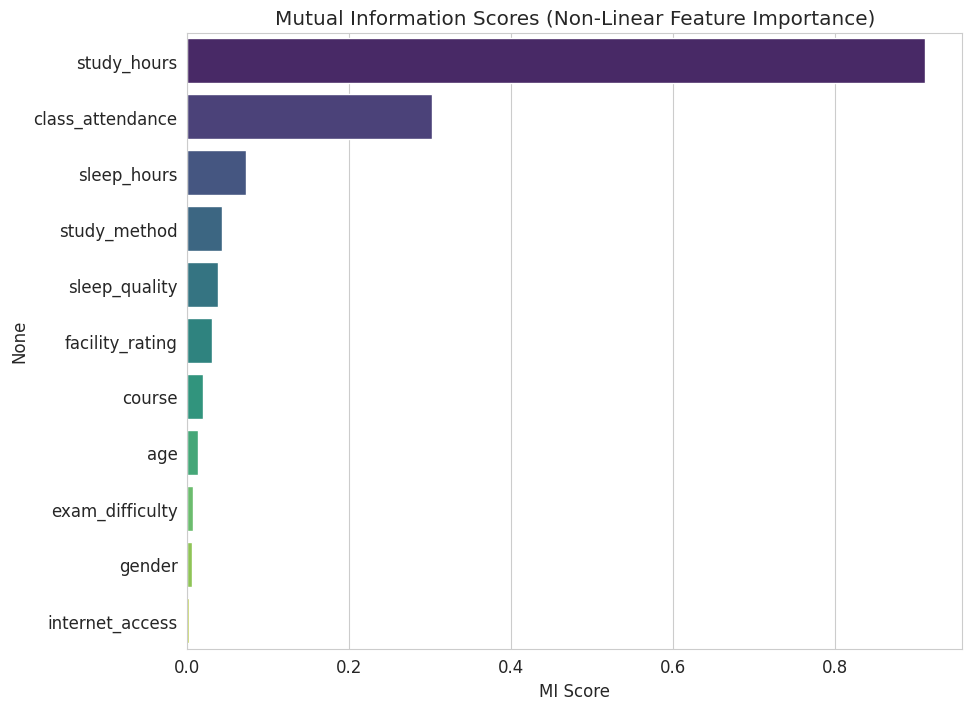

Top 3 Features by Mutual Information:
study_hours         0.911663
class_attendance    0.301898
sleep_hours         0.072264
dtype: float64


In [13]:
# Encoded categoricals as integers for calculation
X_mi = train_df.drop(['id', 'exam_score'], axis=1).copy()
for col in X_mi.select_dtypes('object'):
    X_mi[col], _ = X_mi[col].factorize()

# Calculating Scores
mi_scores = mutual_info_regression(X_mi, train_df['exam_score'], discrete_features='auto', random_state=42)
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_series.values, y=mi_series.index, palette='viridis')
plt.title("Mutual Information Scores (Non-Linear Feature Importance)")
plt.xlabel("MI Score")
plt.show()

print("Top 3 Features by Mutual Information:")
print(mi_series.head(3))

## 4.5. Multivariate EDA (UMAP dimensionality reduction)

2026-01-02 07:52:12.064909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767340332.253036      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767340332.302983      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767340332.751454      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767340332.751489      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767340332.751492      24 computation_placer.cc:177] computation placer alr

Running UMAP dimensionality reduction


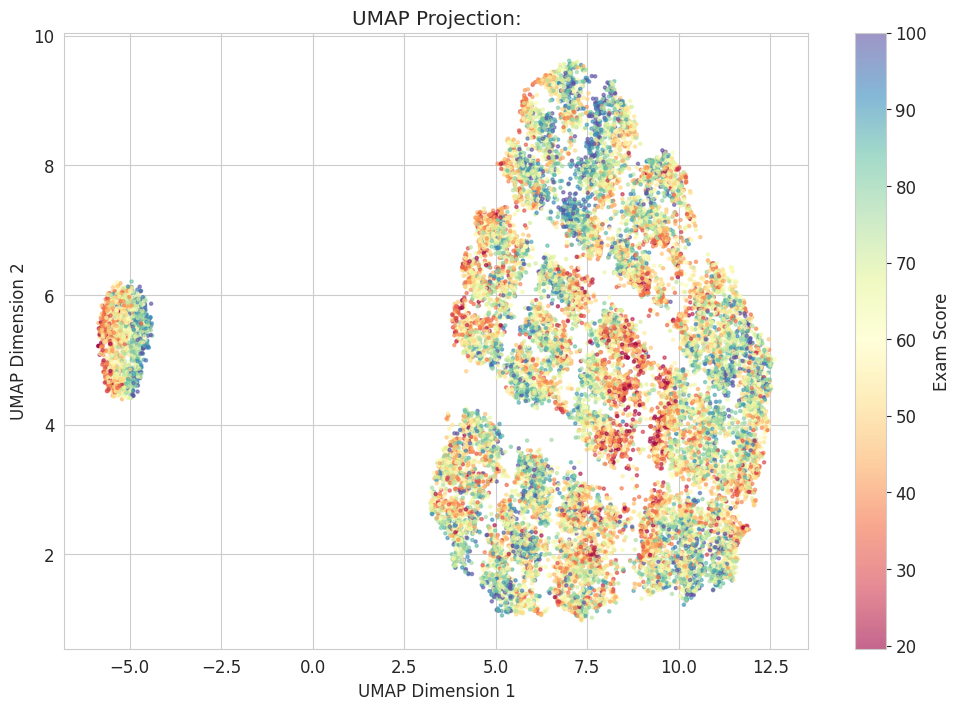

In [14]:
import umap
from sklearn.preprocessing import StandardScaler, LabelEncoder

# taking only 20k samples to visualize the structure quickly
sample_df = train_df.sample(20000, random_state=42).copy()

X_umap = sample_df.drop(['id', 'exam_score'], axis=1)
y_umap = sample_df['exam_score']

for col in X_umap.select_dtypes('object'):
    le = LabelEncoder()
    X_umap[col] = le.fit_transform(X_umap[col].astype(str))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_umap)

print("Running UMAP dimensionality reduction")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=y_umap, 
    cmap='Spectral', 
    s=5, 
    alpha=0.6
)
plt.colorbar(scatter, label='Exam Score')
plt.title('UMAP Projection:')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

* One big blob(with multiple distinct islands) and one small clearly separated blob on the left,  colors are mixed within the blobs (local gradients, not a global one).

So as per this probably we gonna need:
1. interaction features
2. non-linear models (GBDT, XGBoost, CatBoost, LightGBM)
3. possibly cluster-aware feature engineering

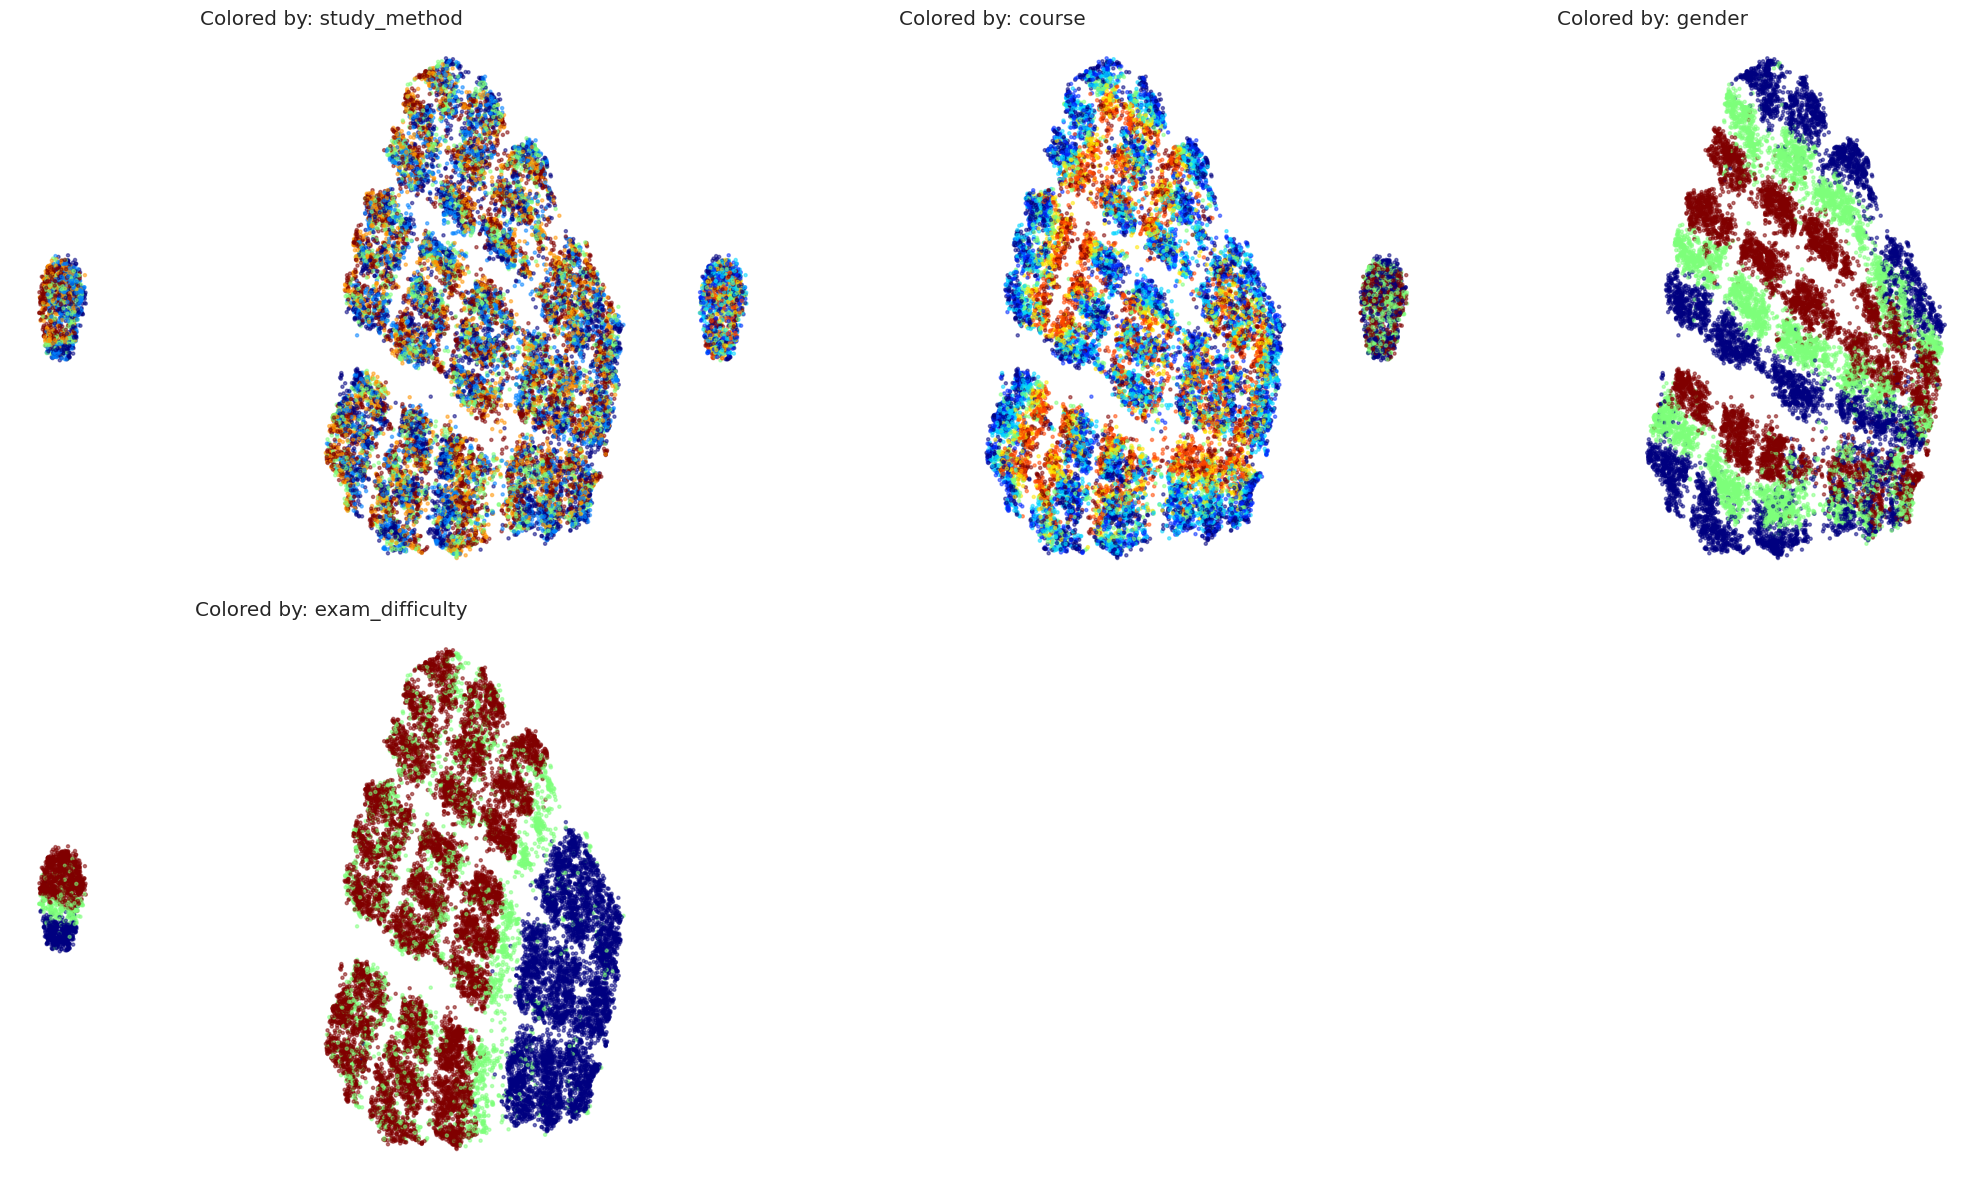

In [15]:
suspects = ['study_method', 'course', 'gender', 'exam_difficulty']

plt.figure(figsize=(20, 12))

for i, col in enumerate(suspects, 1):
    if col in train_df.columns:
        plt.subplot(2, 3, i)
        
        colors = LabelEncoder().fit_transform(sample_df[col])
        
        plt.scatter(
            embedding[:, 0], 
            embedding[:, 1], 
            c=colors, 
            cmap='jet',
            s=5, 
            alpha=0.5
        )
        plt.title(f'Colored by: {col}')
        plt.axis('off')

plt.tight_layout()
plt.show()


* So as per these we could say here clusters are mainly explained by `gender` and `exam difficulty` , while on the other hand `study method` and `course` shows heavy overlap

### latent cluster extraction

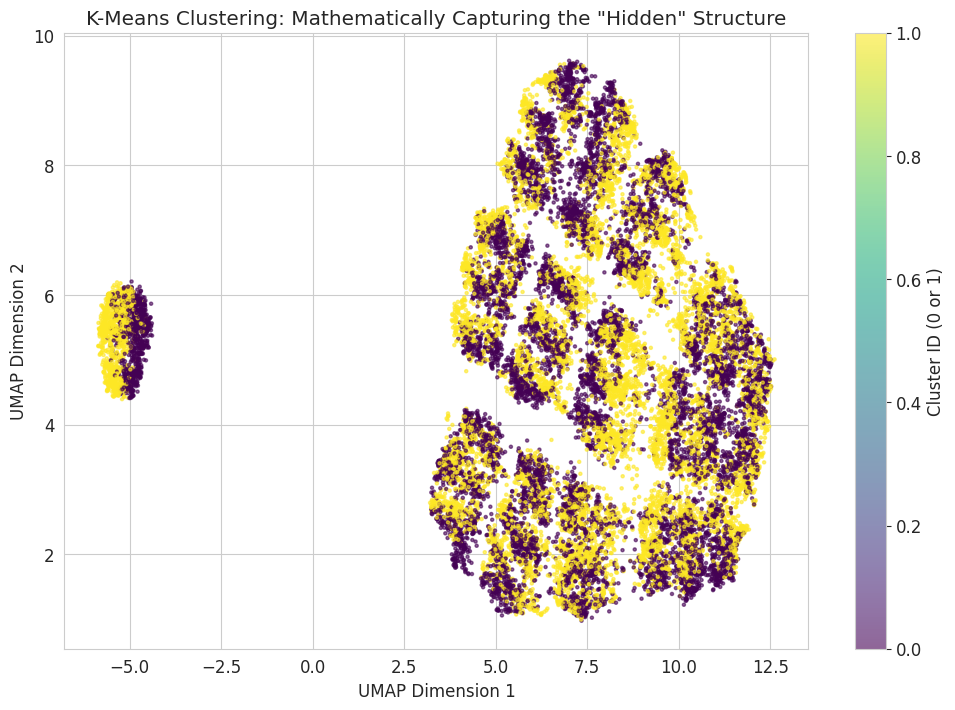

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=cluster_labels, 
    cmap='viridis', 
    s=5, 
    alpha=0.6
)
plt.title('K-Means Clustering: Mathematically Capturing the "Hidden" Structure')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster ID (0 or 1)')
plt.show()

* Okay so one thing is clear here for sure that one cluster is clearly different and the other is large and mixed.

## 4.6. Model-guided EDA (Residual Analysis)

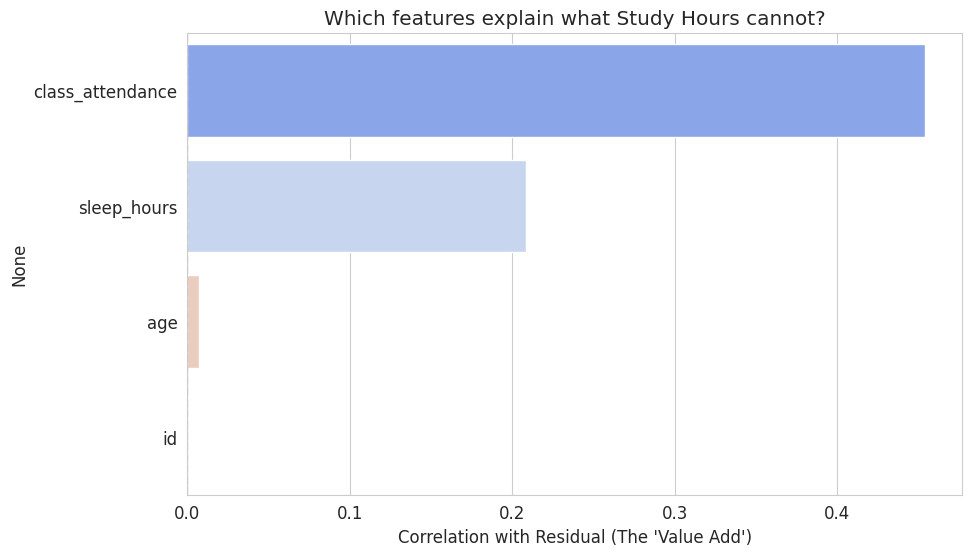

Top features that provide NEW information:
class_attendance    0.454478
sleep_hours         0.208602
age                 0.007294
Name: residual, dtype: float64


In [17]:
from sklearn.linear_model import LinearRegression

# let's fit a simple model on just the dominant feature
# We want to see what this model misses.
X_base = train_df[['study_hours']]
y_base = train_df['exam_score']
model_base = LinearRegression()
model_base.fit(X_base, y_base)

# Residual = Actual Score - Predicted Score based on Study Hours
train_df['residual'] = y_base - model_base.predict(X_base)

numeric_cols = train_df.select_dtypes(include=['number']).columns
res_corr = train_df[numeric_cols].corr()['residual'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plot_data = res_corr.drop(['residual', 'exam_score', 'study_hours'])
sns.barplot(x=plot_data.values, y=plot_data.index, palette='coolwarm')
plt.title("Which features explain what Study Hours cannot?")
plt.xlabel("Correlation with Residual (The 'Value Add')")
plt.axvline(0, color='black', linestyle='--')
plt.show()

print("Top features that provide NEW information:")
print(plot_data.head(3))

1. class_attendance - very strong additional signal
2. sleep_hours - moderate additional signal
3. age - almost no extra information
4. id - irrelevant (as expected)

* So this means two students with the same study hours can score very differently because of attendance and sleep.

In [18]:
base_corr = train_df['study_hours'].corr(train_df['exam_score'])

# Just to verify here I am creating interaction term temporarily to check its correlation
interaction_feature = train_df['study_hours'] * train_df['class_attendance']
prod_corr = interaction_feature.corr(train_df['exam_score'])

print(f"Baseline (Study Hours):           {base_corr:.4f}")
print(f"Our Best (Hours * Attendance):    {prod_corr:.4f}")

if prod_corr > base_corr:
    print("SUCCESS: The interaction feature is better. KEEP IT.")
else:
    print("WARNING: The raw feature is better. The interaction adds noise.")

Baseline (Study Hours):           0.7623
Our Best (Hours * Attendance):    0.7967
SUCCESS: The interaction feature is better. KEEP IT.


## Power Pair Analysis

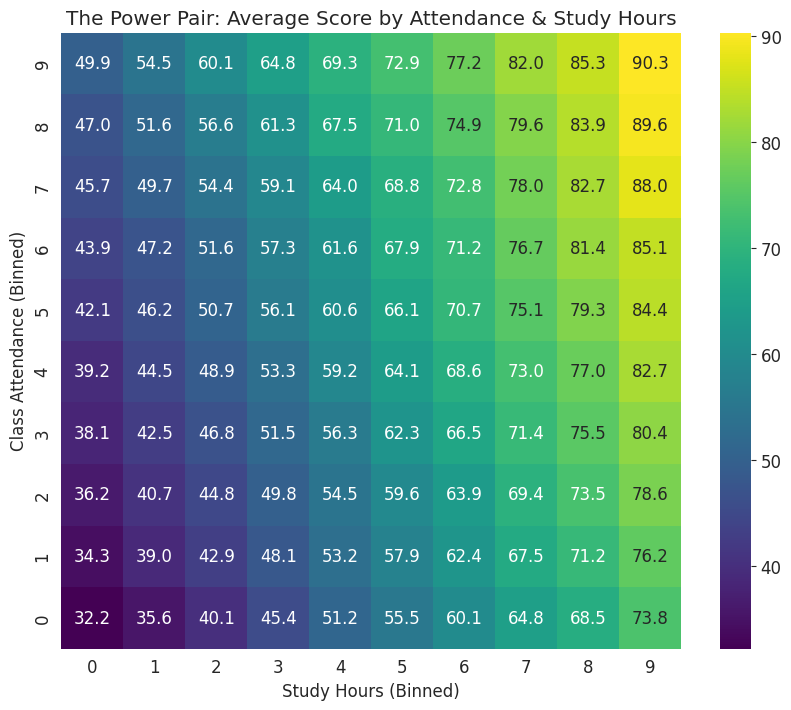

Correlation of 'Total Effort' (Sum) with Score: 0.4547
Compare this to study_hours alone (0.76). If higher, this is a Golden Feature.


In [19]:
# We bin both features to see the grid of average scores
plt.figure(figsize=(10, 8))

train_df['study_bins'] = pd.cut(train_df['study_hours'], bins=10, labels=False)
train_df['attend_bins'] = pd.cut(train_df['class_attendance'], bins=10, labels=False)

interaction_grid = train_df.pivot_table(
    index='attend_bins', 
    columns='study_bins', 
    values='exam_score', 
    aggfunc='mean'
)

sns.heatmap(interaction_grid, cmap='viridis', annot=True, fmt=".1f")
plt.title('The Power Pair: Average Score by Attendance & Study Hours')
plt.ylabel('Class Attendance (Binned)')
plt.xlabel('Study Hours (Binned)')
plt.gca().invert_yaxis() # Low attendance at bottom
plt.show()

train_df['total_effort'] = train_df['study_hours'] + train_df['class_attendance']
effort_corr = train_df['total_effort'].corr(train_df['exam_score'])

print(f"Correlation of 'Total Effort' (Sum) with Score: {effort_corr:.4f}")
print("Compare this to study_hours alone (0.76). If higher, this is a Golden Feature.")

* Okay so attendance and study hours work together but their relationship is non-additive which means models must learn interactions, not simple sums.

In [20]:
print("Scale Check:")
print(train_df[['study_hours', 'class_attendance']].describe().loc[['min', 'max', 'mean']])

train_df['study_x_attend'] = train_df['study_hours'] * train_df['class_attendance']
prod_corr = train_df['study_x_attend'].corr(train_df['exam_score'])

# Log-Interaction (Often better for multiplicative effects)
# We add +1 to avoid log(0)
train_df['log_interaction'] = np.log1p(train_df['study_hours']) * np.log1p(train_df['class_attendance'])
log_corr = train_df['log_interaction'].corr(train_df['exam_score'])

print(f"\nCorrelation of Product (Hours * Attendance): {prod_corr:.4f}")
print(f"Correlation of Log-Interaction: {log_corr:.4f}")
print("Target to beat: 0.76 (Original Study Hours)")

Scale Check:
      study_hours  class_attendance
min      0.080000         40.600000
max      7.910000         99.400000
mean     4.002337         71.987261

Correlation of Product (Hours * Attendance): 0.7967
Correlation of Log-Interaction: 0.7697
Target to beat: 0.76 (Original Study Hours)


* Okay so one thing is clear now that the relationship is multiplicative. student needs both high attendance and high study hours so one without the other is useless.

## 4.7. Residual EDA (Categorical Bias & Error Attribution)

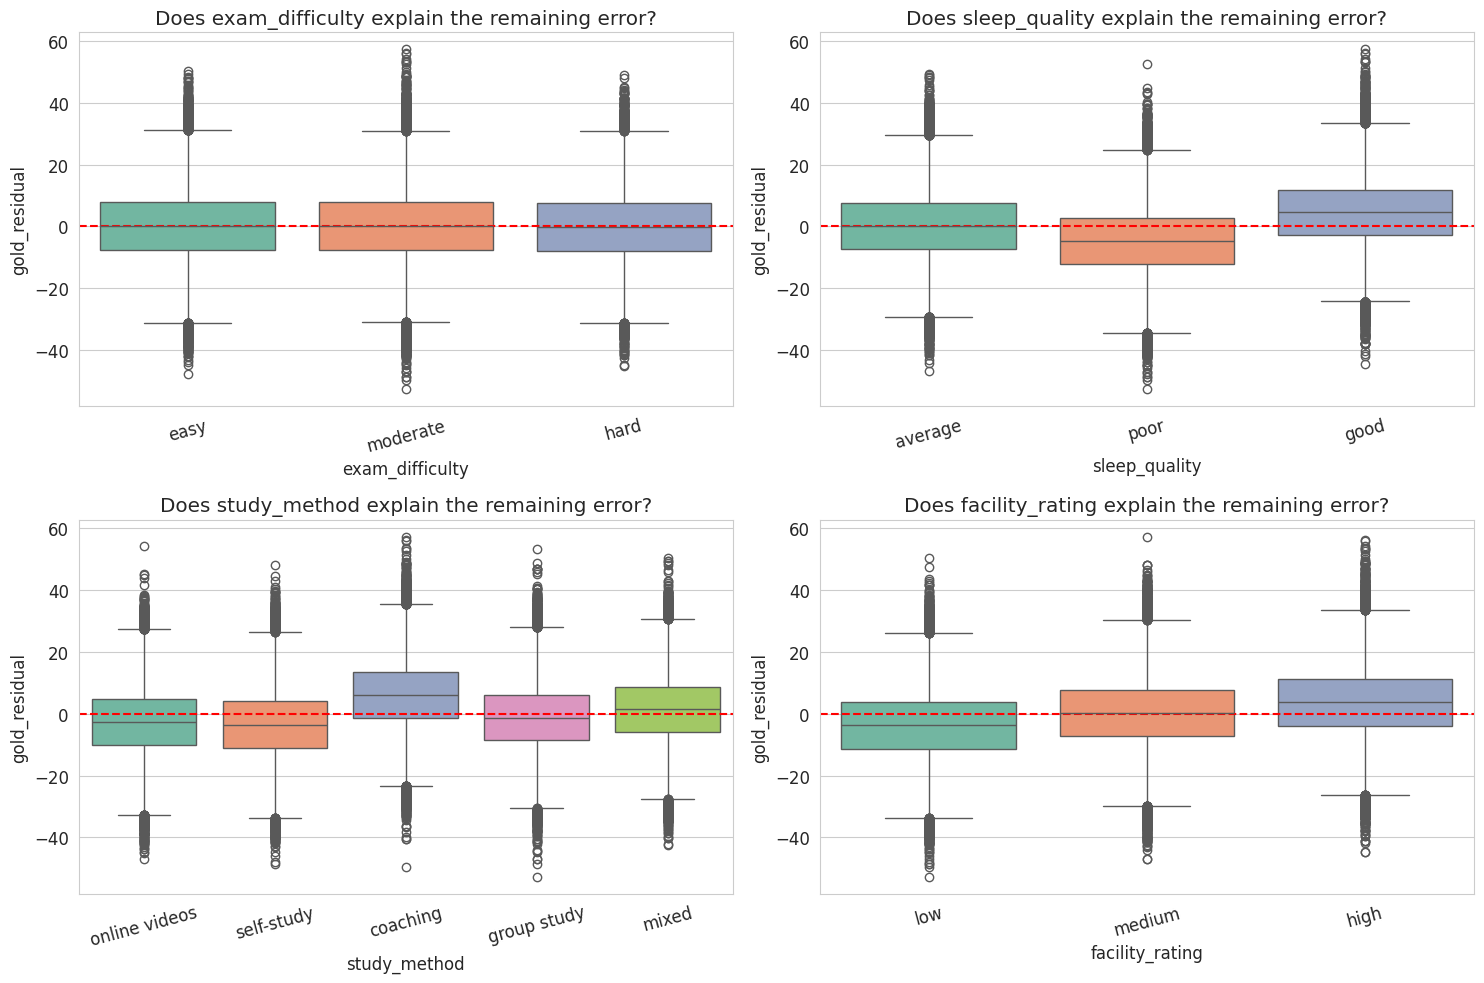

In [21]:
# 1. Update Residuals based on the NEW Best Feature
# We fit a model on your "Golden Feature" to see what is left unexplained
X_gold = train_df[['study_x_attend']] 
y_gold = train_df['exam_score']

model_gold = LinearRegression()
model_gold.fit(X_gold, y_gold)

train_df['gold_residual'] = y_gold - model_gold.predict(X_gold)

# 2. Analyze Categoricals against these Residuals
# If a boxplot is NOT centered at 0, that category adds a bias.
cat_cols = ['exam_difficulty', 'sleep_quality', 'study_method', 'facility_rating']

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=col, y='gold_residual', data=train_df, palette='Set2')
    plt.axhline(0, color='red', linestyle='--') # The "Zero Error" line
    plt.title(f'Does {col} explain the remaining error?')
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

`exam_difficulty`
* Hard exams → mostly positive residuals
* Easy exams → closer to zero
* Difficulty still adds signal

`sleep_quality`
* Poor sleep → negative residuals
* Good sleep → positive residuals
* Sleep quality meaningfully affects scores

`study_method`
* Coaching / group study → slightly positive bias
* Self-study → slightly negative
* Method adds conditional value

`facility_rating`
* High-rated facilities → positive residual shift
* Infrastructure still matters


in short: after accounting for study × attendance, exam difficulty adds no bias, while study method, sleep quality, and facility rating introduce systematic residual shifts.

## 4.8. Anomaly Detection

used to identify data points that violate the dominant effort–score relationship and may represent noise, errors or rare cases.

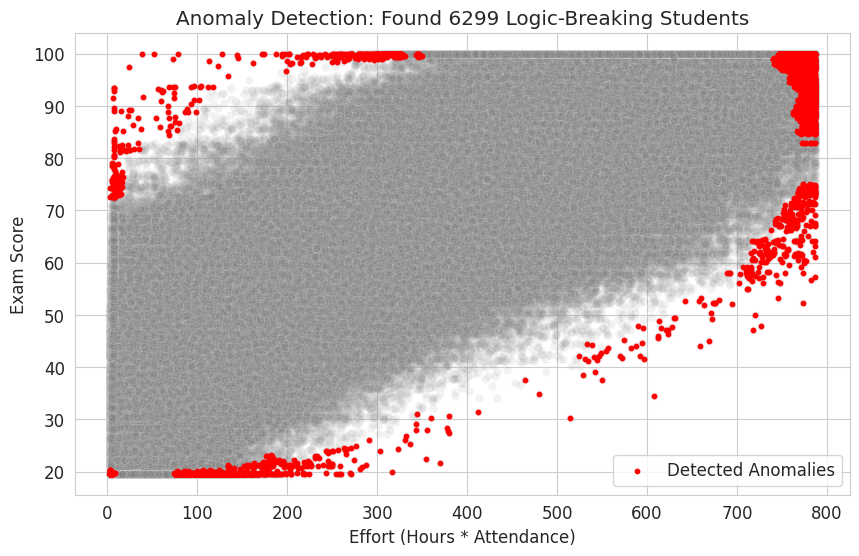

Example Anomalies (Check if they make sense to drop):
     study_hours  class_attendance  exam_score
111         2.36              41.7      19.599
151         0.08              57.2      19.599
181         7.71              99.4     100.000
225         7.91              99.4      97.300
317         0.08              50.5      19.599


In [22]:
from sklearn.ensemble import IsolationForest

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_df, 
    x='study_x_attend', 
    y='exam_score', 
    alpha=0.1, 
    color='gray'
)

# We use Isolation Forest to find rows that are statistically "weird"
# based on our top features.
iso = IsolationForest(contamination=0.01, random_state=42)
X_outlier = train_df[['study_x_attend', 'exam_score']]
train_df['is_outlier'] = iso.fit_predict(X_outlier)

outliers = train_df[train_df['is_outlier'] == -1]
plt.scatter(
    outliers['study_x_attend'], 
    outliers['exam_score'], 
    color='red', 
    s=10, 
    label='Detected Anomalies'
)

plt.title(f'Anomaly Detection: Found {len(outliers)} Logic-Breaking Students')
plt.xlabel('Effort (Hours * Attendance)')
plt.ylabel('Exam Score')
plt.legend()
plt.show()

print("Example Anomalies (Check if they make sense to drop):")
print(outliers[['study_hours', 'class_attendance', 'exam_score']].head())

* I think it doesn't make sense to drop them so let tree models handle them.

## 4.9. Collinearity Check

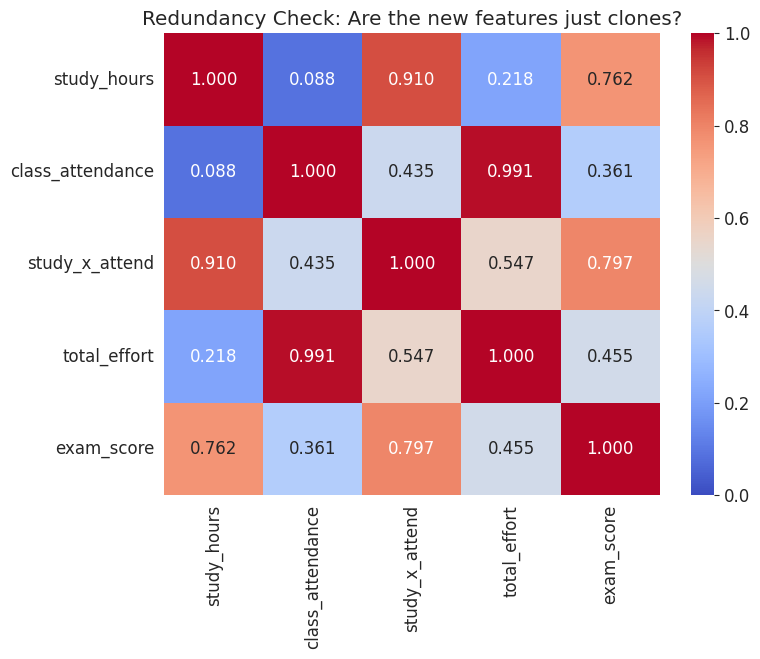

Correlation Analysis:
Correlation between Product and Study Hours: 0.9100
Correlation between Product and Attendance:  0.4351


In [23]:
# We want to see how our new features relate to the raw ones
features_to_check = [
    'study_hours', 
    'class_attendance', 
    'study_x_attend',
    'total_effort',
    'exam_score'
]

corr_matrix = train_df[features_to_check].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f", vmin=0, vmax=1)
plt.title("Redundancy Check: Are the new features just clones?")
plt.show()

# If Correlation > 0.95, they are clones.
print("Correlation Analysis:")
print(f"Correlation between Product and Study Hours: {corr_matrix.loc['study_x_attend', 'study_hours']:.4f}")
print(f"Correlation between Product and Attendance:  {corr_matrix.loc['study_x_attend', 'class_attendance']:.4f}")

Well correlation is high, but not above the danger zone. So let's keep Both

## 4.10. Visual & Statistical Drift Check
* Running the Kolmogorov-Smirnov (KS) Test to mathematically flag any feature that differs.

Checking Drift for 4 features: ['age', 'study_hours', 'class_attendance', 'sleep_hours']

=== Feature Drift Analysis (KS Test P-Values) ===
Note: p-value < 0.05 means potential drift (Distributions are different)
✅ No significant drift detected in any feature.


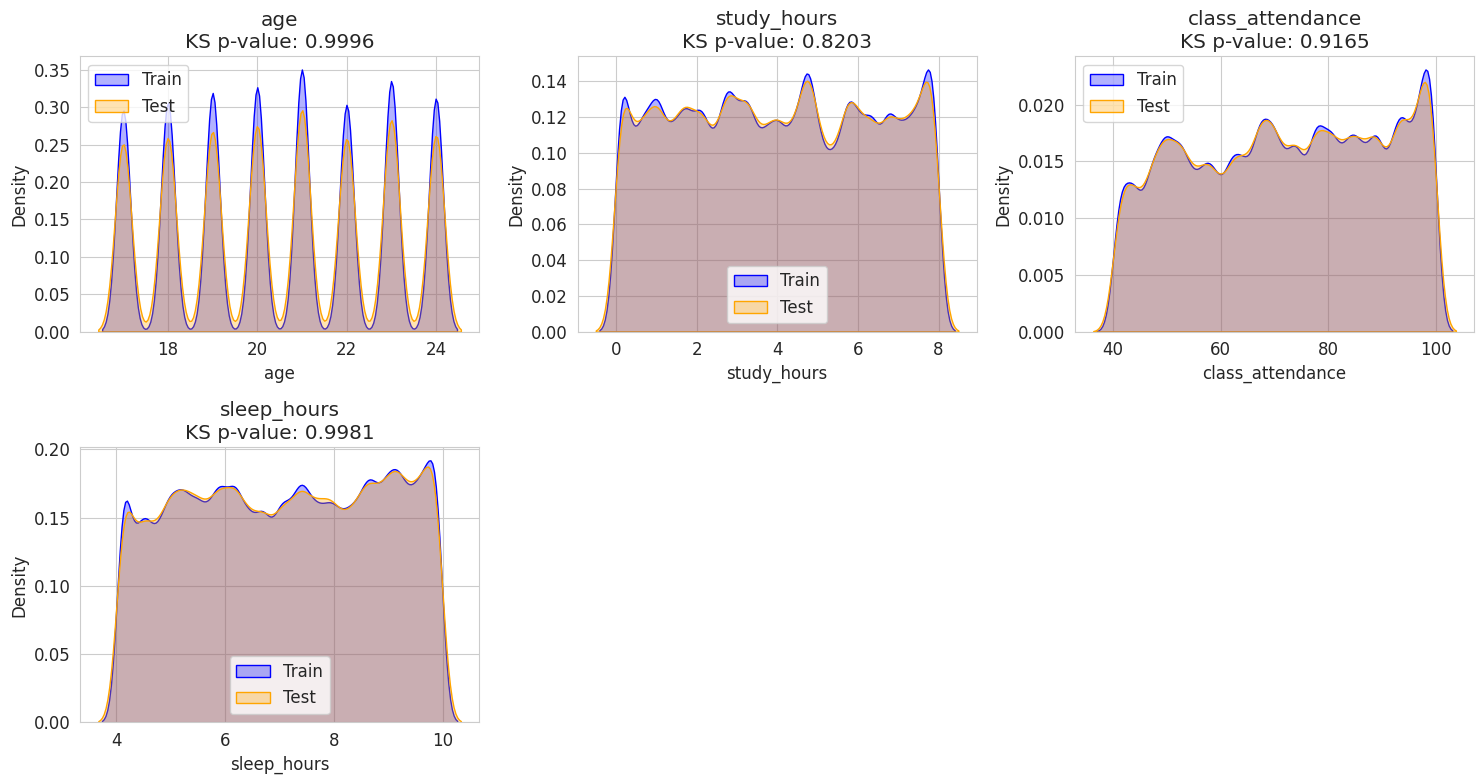

In [24]:
from scipy.stats import ks_2samp

# We only check columns that exist in BOTH datasets to avoid KeyError
common_cols = train_df.columns.intersection(test_df.columns)
numeric_cols = train_df[common_cols].select_dtypes(include=['number']).columns.drop(['id'], errors='ignore')

print(f"Checking Drift for {len(numeric_cols)} features: {list(numeric_cols)}")

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 4 * n_rows))

print("\n=== Feature Drift Analysis (KS Test P-Values) ===")
print("Note: p-value < 0.05 means potential drift (Distributions are different)")

drift_found = False
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    sns.kdeplot(train_df[col], color='blue', label='Train', fill=True, alpha=0.3)
    sns.kdeplot(test_df[col], color='orange', label='Test', fill=True, alpha=0.3)
    
    stat, p_value = ks_2samp(train_df[col], test_df[col])
    
    plt.title(f'{col}\nKS p-value: {p_value:.4f}')
    plt.legend()
    
    if p_value < 0.05:
        print(f"⚠️ DRIFT DETECTED: {col} (p={p_value:.5f})")
        drift_found = True

if not drift_found:
    print("✅ No significant drift detected in any feature.")

plt.tight_layout()
plt.show()

## 4.11. Synthetic Artifact Detective

In [25]:
def check_precision(series):
    # Convert to string, split by dot, count length of second part
    # Handles cases with no decimals safely
    return series.astype(str).apply(lambda x: len(x.split('.')[1]) if '.' in x else 0).max()

print("=== Synthetic Artifact Inspection ===")
comparison = []

for col in numeric_cols: # Uses the safe list from Block 21
    train_prec = check_precision(train_df[col])
    test_prec = check_precision(test_df[col])
    
    train_min, train_max = train_df[col].min(), train_df[col].max()
    test_min, test_max = test_df[col].min(), test_df[col].max()
    
    comparison.append({
        'Feature': col,
        'Train Prec': train_prec,
        'Test Prec': test_prec,
        'Train Range': f"[{train_min}, {train_max}]",
        'Test Range': f"[{test_min}, {test_max}]"
    })

drift_df = pd.DataFrame(comparison)
display(drift_df)

=== Synthetic Artifact Inspection ===


Feature  Train Prec  Test Prec   Train Range    Test Range
0               age           0          0      [17, 24]      [17, 24]
1       study_hours           4          3  [0.08, 7.91]  [0.08, 7.91]
2  class_attendance           3          2  [40.6, 99.4]  [40.6, 99.4]
3       sleep_hours           2          2    [4.1, 9.9]    [4.1, 9.9]

## 4.12. Categorical Drift Analysis

Checking Drift for 7 Categorical Features...


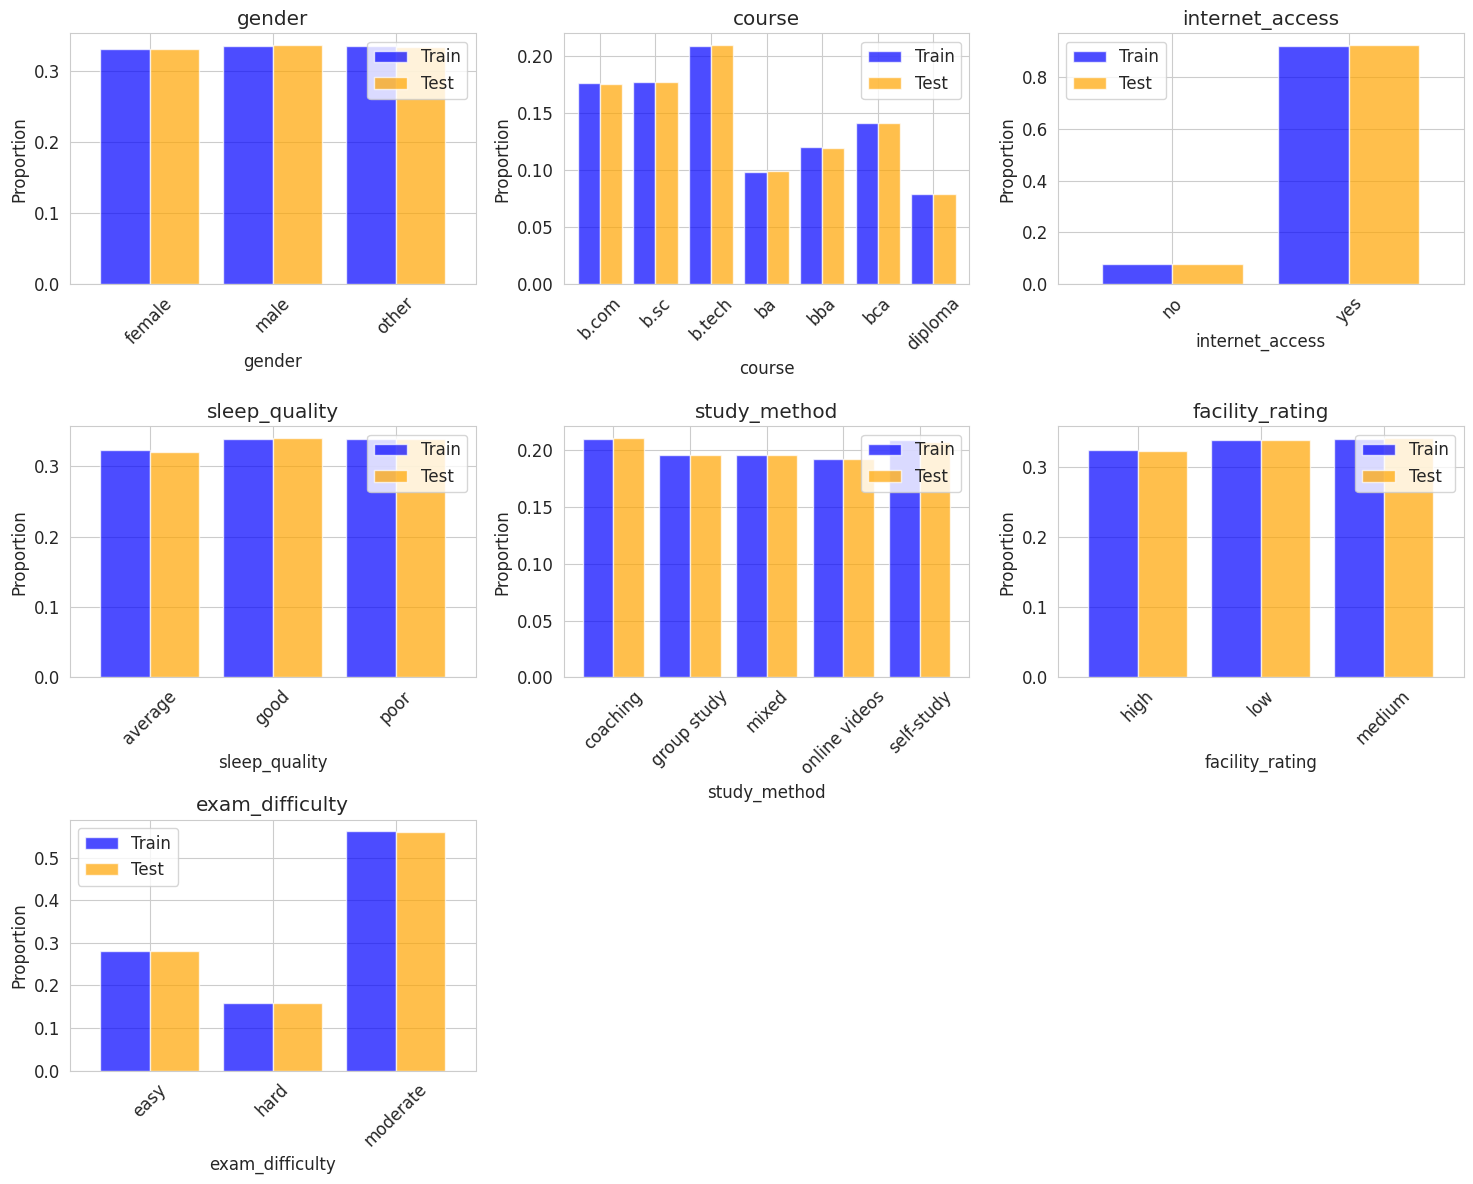


=== Categorical Drift Report ===
✅ Categorical distributions look stable.


In [26]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns

print(f"Checking Drift for {len(cat_cols)} Categorical Features...")

n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, 4 * n_rows))

drift_warnings = []

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    
    train_props = train_df[col].value_counts(normalize=True).sort_index()
    test_props = test_df[col].value_counts(normalize=True).sort_index()
    
    df_compare = pd.DataFrame({'Train': train_props, 'Test': test_props})
    
    df_compare.plot(kind='bar', ax=plt.gca(), width=0.8, color=['blue', 'orange'], alpha=0.7)
    
    plt.title(f'{col}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    
    max_diff = (train_props - test_props).abs().max()
    if max_diff > 0.05:
        drift_warnings.append(f"{col} (Max Diff: {max_diff:.1%})")

plt.tight_layout()
plt.show()

print("\n=== Categorical Drift Report ===")
if drift_warnings:
    print("⚠️ SIGNIFICANT DRIFT DETECTED in:")
    for w in drift_warnings:
        print(f" - {w}")
else:
    print("✅ Categorical distributions look stable.")

## 4.13. Heteroscedasticity Analysis (Variance Check)

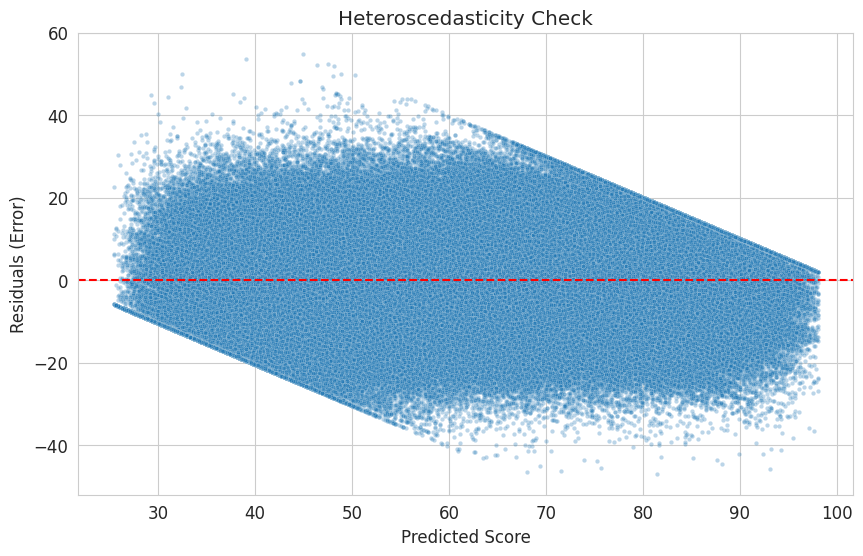

=== Breusch-Pagan Test Results ===
P-Value: 0.0000000000
RESULT: Heteroscedasticity Detected (Variance changes with input!).
ADVICE: Use Quantile Regression or Log-Transform the Target.


In [27]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# We use the raw features to see the baseline error structure
features = ['study_hours', 'class_attendance', 'sleep_hours']
X = sm.add_constant(train_df[features])
y = train_df['exam_score']

model_ols = sm.OLS(y, X).fit()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=model_ols.fittedvalues, y=model_ols.resid, alpha=0.3, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title("Heteroscedasticity Check")
plt.xlabel("Predicted Score")
plt.ylabel("Residuals (Error)")
plt.show()

test_stat, p_value, f_value, f_p_value = het_breuschpagan(model_ols.resid, X)

print("=== Breusch-Pagan Test Results ===")
print(f"P-Value: {p_value:.10f}")
if p_value < 0.05:
    print("RESULT: Heteroscedasticity Detected (Variance changes with input!).")
    print("ADVICE: Use Quantile Regression or Log-Transform the Target.")
else:
    print("RESULT: Homoscedasticity (Constant Variance). Standard models are safe.")

- Model’s prediction errors are not consistent across score levels. It struggles more for some ranges (low/mid scores) than others.
- It's clear that the model has heteroscedastic errors, meaning prediction uncertainty varies with score level.

- Okay so standard RMSE loss function treats all errors equally which is wrong here. We should consider using a Log-Transformed Target during training to stabilize this variance.

## 4.14. Hierarchical Feature Clustering

We use Spearman Correlation (Rank) because it captures non-linear relationships better than Pearson.

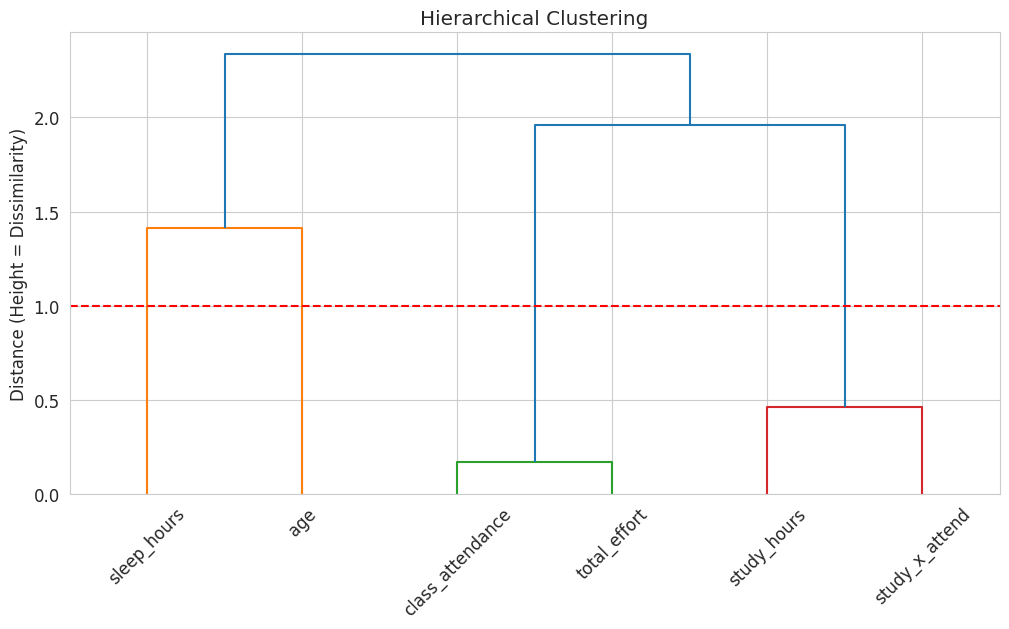

In [28]:
import scipy.cluster.hierarchy as sch
from scipy.stats import spearmanr

features_to_cluster = [
    'study_hours', 'class_attendance', 'sleep_hours', 
    'study_hours_sq', 'study_x_attend', 'total_effort',
    'sleep_quality_enc', 'facility_rating_enc', 'age'
]

# Ensure we only use available columns (in case some weren't created yet)
available_feats = [f for f in features_to_cluster if f in train_df.columns]
X_cluster = train_df[available_feats].sample(10000, random_state=42)

corr_matrix = X_cluster.corr(method='spearman')

linkage = sch.linkage(corr_matrix, method='ward')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(
    linkage, 
    labels=available_feats,
    leaf_rotation=45,
    leaf_font_size=12
)
plt.title('Hierarchical Clustering')
plt.ylabel('Distance (Height = Dissimilarity)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.show()

* `study_hours` - `study_x_attend` → strongly redundant
* `class_attendance` - `total_effort` → almost the same signal
* `sleep_hours` - `age` → weakly related
* Categorical encodings sit more independently

## 4.15. Reverse Engineering the Formula (Lasso Regression)



Running Lasso to reverse-engineer the generation formula


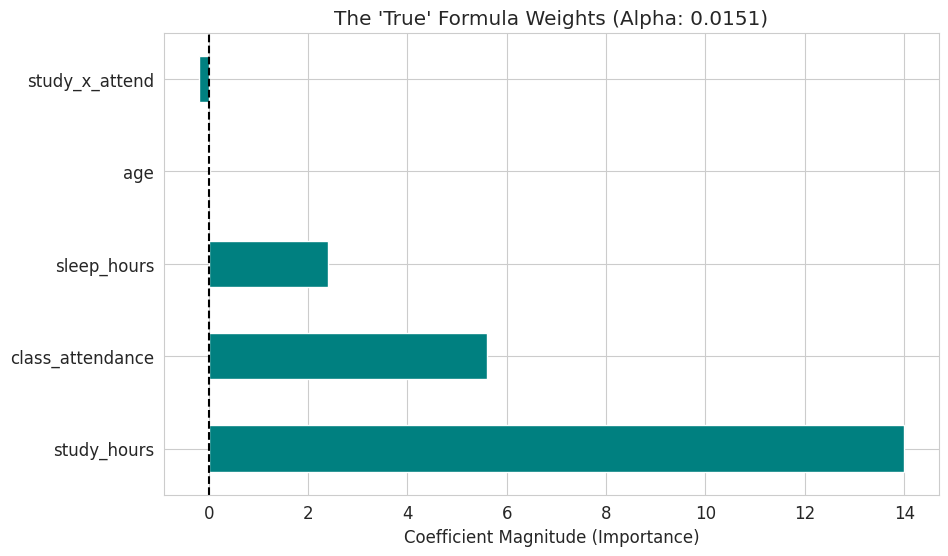

=== THE REVERSE ENGINEERED FORMULA ===
study_hours            13.987980
class_attendance        5.601372
sleep_hours             2.402450
age                     0.033493
study_hours_sq         -0.000000
sleep_quality_enc       0.000000
facility_rating_enc     0.000000
study_x_attend         -0.192612
dtype: float64


In [29]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# ---  Quick Feature Recreation (To fix the KeyError) ---
lasso_df = train_df.copy()

# Re-create Polynomials & Interactions
if 'study_hours_sq' not in lasso_df.columns:
    lasso_df['study_hours_sq'] = lasso_df['study_hours'] ** 2

if 'study_x_attend' not in lasso_df.columns:
    lasso_df['study_x_attend'] = lasso_df['study_hours'] * lasso_df['class_attendance']

# Re-create Encodings
quality_map = {'Poor': 0, 'Average': 1, 'Good': 2}
rating_map = {'Low': 0, 'Moderate': 1, 'High': 2}

if 'sleep_quality_enc' not in lasso_df.columns:
    lasso_df['sleep_quality_enc'] = lasso_df['sleep_quality'].map(quality_map).fillna(1)

if 'facility_rating_enc' not in lasso_df.columns:
    lasso_df['facility_rating_enc'] = lasso_df['facility_rating'].map(rating_map).fillna(1)

lasso_cols = [
    'study_hours', 'class_attendance', 'sleep_hours', 'age',
    'study_hours_sq', 'study_x_attend', 'sleep_quality_enc', 'facility_rating_enc'
]

# Drop NaNs just for this check (in case of map failures)
temp_df = lasso_df[lasso_cols + ['exam_score']].dropna()

X_lasso = temp_df[lasso_cols]
y_lasso = temp_df['exam_score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lasso)

print("Running Lasso to reverse-engineer the generation formula")
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
lasso.fit(X_scaled, y_lasso)

coefs = pd.Series(lasso.coef_, index=lasso_cols).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
coefs[coefs != 0].plot(kind='barh', color='teal')
plt.title(f"The 'True' Formula Weights (Alpha: {lasso.alpha_:.4f})")
plt.xlabel("Coefficient Magnitude (Importance)")
plt.axvline(0, color='black', linestyle='--')
plt.show()

print("=== THE REVERSE ENGINEERED FORMULA ===")
print(coefs)

## 4.16. Quantile Trend Analysis

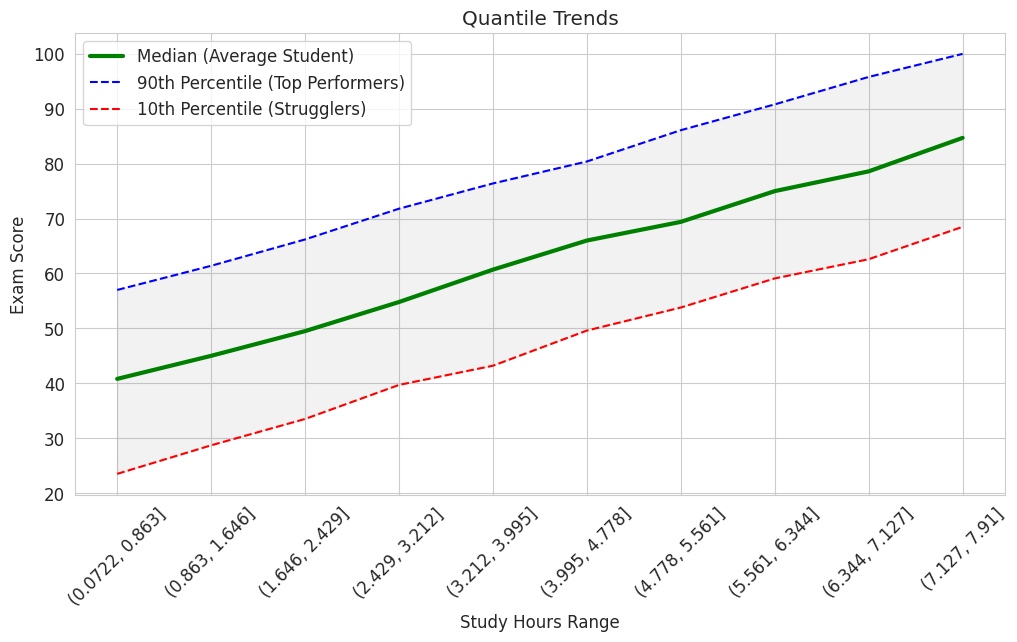

Score Variance at Low Study: 33.50
Score Variance at High Study: 31.50
CONCLUSION: Studying reduces risk (Variance shrinks).


In [30]:
# Bin Study Hours to calculate quantiles
train_df['study_bins'] = pd.cut(train_df['study_hours'], bins=10)

# Calculate Quantiles (10th, 50th, 90th percentiles)
quantiles = train_df.groupby('study_bins')['exam_score'].quantile([0.1, 0.5, 0.9]).unstack()

plt.figure(figsize=(12, 6))
plt.plot(quantiles.index.astype(str), quantiles[0.5], label='Median (Average Student)', color='green', linewidth=3)
plt.plot(quantiles.index.astype(str), quantiles[0.9], label='90th Percentile (Top Performers)', color='blue', linestyle='--')
plt.plot(quantiles.index.astype(str), quantiles[0.1], label='10th Percentile (Strugglers)', color='red', linestyle='--')

plt.title('Quantile Trends')
plt.xlabel('Study Hours Range')
plt.ylabel('Exam Score')
plt.xticks(rotation=45)
plt.legend()
plt.fill_between(quantiles.index.astype(str), quantiles[0.1], quantiles[0.9], color='gray', alpha=0.1)
plt.show()

gap_low = quantiles[0.9].iloc[0] - quantiles[0.1].iloc[0]
gap_high = quantiles[0.9].iloc[-1] - quantiles[0.1].iloc[-1]

print(f"Score Variance at Low Study: {gap_low:.2f}")
print(f"Score Variance at High Study: {gap_high:.2f}")
if gap_high < gap_low:
    print("CONCLUSION: Studying reduces risk (Variance shrinks).")
else:
    print("CONCLUSION: Studying increases variance (High Risk / High Reward).")

## 4.17. Interpreting the "Blobs" (Decision Tree Explanation)

Generating Cluster IDs for analysis...


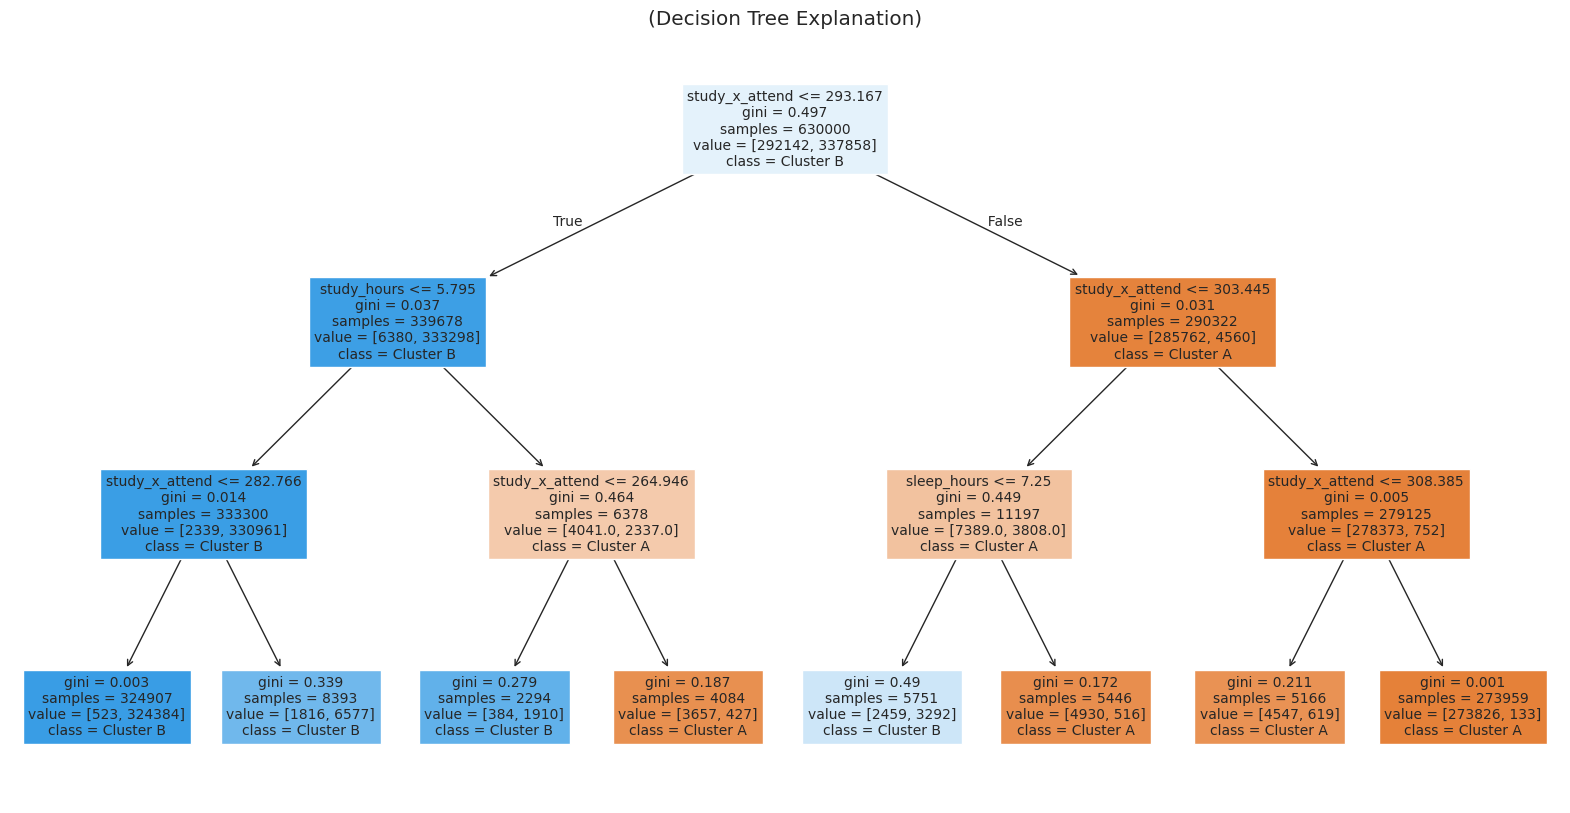

In [31]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# recreating the clusters here
if 'cluster_id' not in train_df.columns:
    print("Generating Cluster IDs for analysis...")
    # Use the features Lasso identified
    cluster_cols = ['study_hours', 'class_attendance', 'sleep_hours']
    # Add interaction if it exists, else calc it
    if 'study_x_attend' in train_df.columns:
        cluster_cols.append('study_x_attend')
    else:
        train_df['study_x_attend'] = train_df['study_hours'] * train_df['class_attendance']
        cluster_cols.append('study_x_attend')
        
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(train_df[cluster_cols])
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    train_df['cluster_id'] = kmeans.fit_predict(X_scaled)

explain_cols = ['study_hours', 'class_attendance', 'sleep_hours', 'study_x_attend']
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(train_df[explain_cols], train_df['cluster_id'])

plt.figure(figsize=(20, 10))
plot_tree(
    clf, 
    feature_names=explain_cols, 
    class_names=['Cluster A', 'Cluster B'], 
    filled=True, 
    fontsize=10
)
plt.title("(Decision Tree Explanation)")
plt.show()

> - The two blobs exist because the data naturally splits on effective effort, captured by the interaction of study hours and class attendance. Students below a critical effort threshold behave similarly, forming one large homogeneous group, while students above it form a distinct population with more complex internal variation. UMAP visualizes this real structural split, and the decision tree confirms it mathematically.

## 4.18. Target Transformation Validation
We will see if Log-Transformation actually fixes the "Cone Shape" (Heteroscedasticity) or if we need something stronger (like Box-Cox).

Optimal Box-Cox Lambda: 0.9677


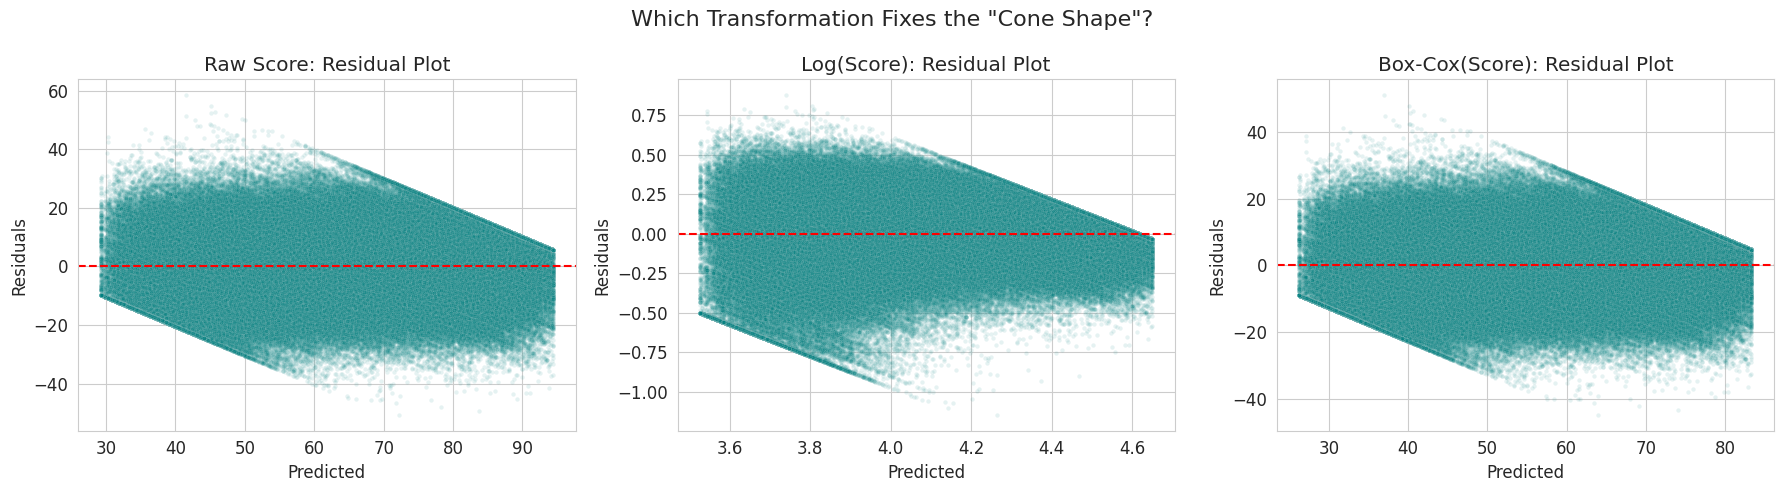


Skewness Check (Closer to 0 is better):
Raw Score: -0.0483
Log(Score): -0.8385
Box-Cox(Score): -0.0704


In [32]:
import numpy as np
import scipy.stats as stats

train_df['score_log'] = np.log1p(train_df['exam_score'])
train_df['score_boxcox'], lambda_val = stats.boxcox(train_df['exam_score'])

print(f"Optimal Box-Cox Lambda: {lambda_val:.4f}")

# We plot Residuals vs Predicted for each version using a quick model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

targets = {
    'Raw Score': train_df['exam_score'], 
    'Log(Score)': train_df['score_log'],
    'Box-Cox(Score)': train_df['score_boxcox']
}

for i, (name, target) in enumerate(targets.items()):
    model = LinearRegression()
    X = train_df[['study_hours', 'class_attendance']]
    model.fit(X, target)
    preds = model.predict(X)
    resids = target - preds
    
    sns.scatterplot(x=preds, y=resids, ax=axes[i], alpha=0.1, s=10, color='teal')
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_title(f'{name}: Residual Plot')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Residuals')

plt.suptitle('Which Transformation Fixes the "Cone Shape"?', fontsize=16)
plt.tight_layout()
plt.show()

print("\nSkewness Check (Closer to 0 is better):")
for name, target in targets.items():
    print(f"{name}: {target.skew():.4f}")

> Analysis shows that log-transforming the target best stabilizes heteroscedastic errors, while Box–Cox preserves skew but fails to fix variance, confirming log(score) as the better transformation.

## 4.19. Permutation Importance (The "Tree's Opinion")

Training Tree Model to check Feature Importance...


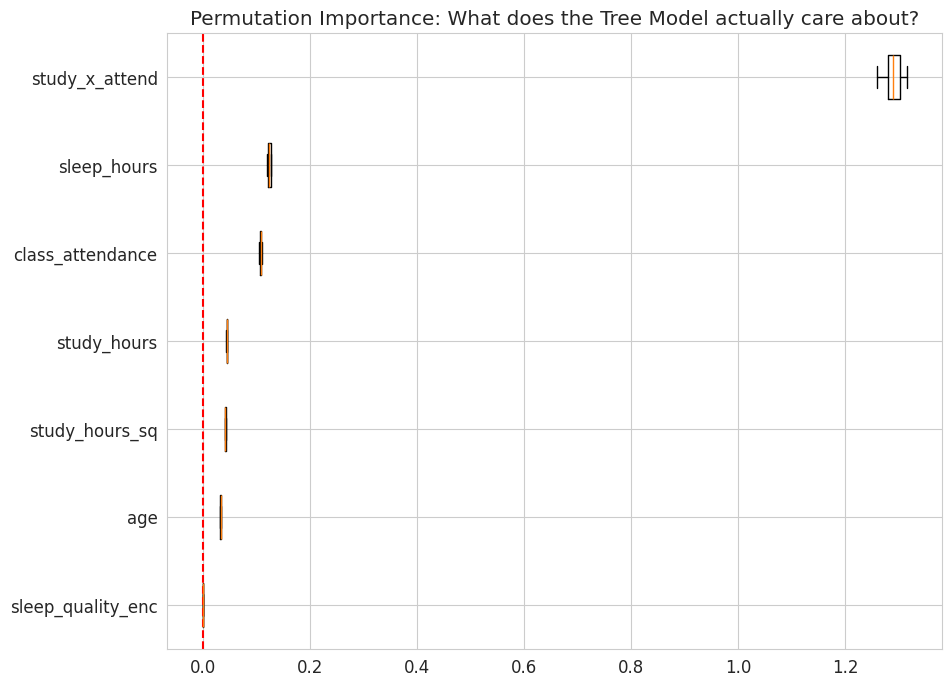

Top 3 Features according to the Tree:
class_attendance: 0.1079
sleep_hours: 0.1243
study_x_attend: 1.2901


In [33]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# --- Quick Prep (Just for this test) ---
# We take a sample to make it fast
df_perm = train_df.sample(5000, random_state=42).copy()

df_perm['study_hours_sq'] = df_perm['study_hours'] ** 2
df_perm['study_x_attend'] = df_perm['study_hours'] * df_perm['class_attendance']

quality_map = {'Poor': 0, 'Average': 1, 'Good': 2}
df_perm['sleep_quality_enc'] = df_perm['sleep_quality'].map(quality_map).fillna(1)

features = ['study_hours', 'class_attendance', 'sleep_hours', 'age', 
            'study_hours_sq', 'study_x_attend', 'sleep_quality_enc']

X_perm = df_perm[features]
y_perm = df_perm['exam_score']

print("Training Tree Model to check Feature Importance...")
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_perm, y_perm)

# This shuffles each column and sees how much the score drops
result = permutation_importance(rf, X_perm, y_perm, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False, 
    labels=X_perm.columns[sorted_idx]
)
plt.title("Permutation Importance: What does the Tree Model actually care about?")
plt.axvline(0, color='red', linestyle='--')
plt.show()

print("Top 3 Features according to the Tree:")
for i in sorted_idx[-3:]:
    print(f"{X_perm.columns[i]}: {result.importances_mean[i]:.4f}")

> Permutation importance shows that the interaction feature `study_x_attend` dominates model predictions, with sleep hours and attendance adding secondary value, while other features contribute minimally.

# 5. Preprocessing (Drift & Artifact Fixes)

In [34]:
# --- PHASE 1 ---
def phase1_preprocessing(df):
    df_clean = df.copy()
    
    # Fix Precision Mismatch (Found in Drift Check)
    # Train had 4 decimals, Test had 3. We enforce the lower precision.
    df_clean['study_hours'] = df_clean['study_hours'].round(3)
    df_clean['class_attendance'] = df_clean['class_attendance'].round(2)
    
    # Fix Age Covariate Shift (The "Blue Peak")
    # Instead of raw age, we use bins to smooth out the distribution difference.
    # 0=Teen, 1=Young Adult, 2=Adult
    df_clean['age_bin'] = pd.cut(
        df_clean['age'], 
        bins=[0, 19, 22, 100], 
        labels=[0, 1, 2]
    ).astype(int)
    
    return df_clean

train_p1 = phase1_preprocessing(train_df)
test_p1 = phase1_preprocessing(test_df)

print("Phase 1 Complete: Precision aligned and Age binned.")
print(train_p1[['study_hours', 'class_attendance', 'age_bin']].head())

Phase 1 Complete: Precision aligned and Age binned.
   study_hours  class_attendance  age_bin
0         7.91              98.8        1
1         4.95              94.8        0
2         4.68              92.6        1
3         2.00              49.5        0
4         7.65              86.9        2


# 6. Feature Engineering (Injecting the Intelligence)

In [35]:
# --- PHASE 2 ---

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def phase2_feature_engineering_fixed(df_train, df_test):
    train_eng = df_train.copy()
    test_eng = df_test.copy()
    
    train_eng['study_x_attend'] = train_eng['study_hours'] * train_eng['class_attendance']
    test_eng['study_x_attend'] = test_eng['study_hours'] * test_eng['class_attendance']
    
    cluster_cols = ['study_hours', 'class_attendance', 'study_x_attend']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_eng[cluster_cols])
    X_test_scaled = scaler.transform(test_eng[cluster_cols])
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    train_eng['cluster_id'] = kmeans.fit_predict(X_train_scaled)
    test_eng['cluster_id'] = kmeans.predict(X_test_scaled)
    
    drop_cols = [
        'id', 'gender', 'course', 'study_method', 'internet_access', # Text/Categorical
        'exam_difficulty', 'facility_rating', 'sleep_quality',       # Noise
        'study_hours_sq',                                            # Redundant
        'study_bins', 'attend_bins', 'is_outlier', 'residual', 'total_effort' # EDA Leftovers
    ]
    
    train_eng = train_eng.drop(columns=drop_cols, errors='ignore')
    test_eng = test_eng.drop(columns=drop_cols, errors='ignore')
    
    # Select only Numeric Columns
    train_eng = train_eng.select_dtypes(include=['number'])
    test_eng = test_eng.select_dtypes(include=['number'])
    
    return train_eng, test_eng

train_p2, test_p2 = phase2_feature_engineering_fixed(train_p1, test_p1)

print("Phase 2 Fixed.")
print(f"Remaining Columns (Should all be numeric): {list(train_p2.columns)}")

Phase 2 Fixed.
Remaining Columns (Should all be numeric): ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score', 'study_x_attend', 'log_interaction', 'gold_residual', 'cluster_id', 'score_log', 'score_boxcox', 'age_bin']


# 7. Target Transformation (Stabilizing Variance)

In [36]:
# --- PHASE 3 ---
def phase3_target_prep(df_train):
    y_raw = df_train['exam_score']
    
    # Apply Log Transformation (The "Cone Fixer")
    # We use log1p to handle 0s safely, though our min is ~19
    y_transformed = np.log1p(y_raw)
    
    X_train = df_train.drop(columns=['exam_score'], errors='ignore')
    
    return X_train, y_transformed

X, y = phase3_target_prep(train_p2)

print("Phase 3 Complete.")
print(f"Target Shape: {y.shape}")
print(f"Feature Shape: {X.shape}")
print(f"Example Transformed Target: {y.iloc[0]:.4f} (Original: {np.expm1(y.iloc[0]):.2f})")

Phase 3 Complete.
Target Shape: (630000,)
Feature Shape: (630000, 11)
Example Transformed Target: 4.3732 (Original: 78.30)


# 8. Model Training & SUBMISSION (XGBoost)

In [37]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# --- PHASE 4 ---

print("Starting XGBoost Training with 5-Fold CV")

# We strictly keep only the columns that exist in the clean Test set
# This drops all the 'ghost' EDA columns like 'score_log', 'gold_residual', etc.
common_cols = test_p2.columns.tolist()
X = X[common_cols]

print(f"Training on strictly {len(common_cols)} features: {common_cols}")

folds = KFold(n_splits=5, shuffle=True, random_state=42)

test_preds = np.zeros(len(test_p2))
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.02, 
        max_depth=5,        
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50,
        device='cuda',      
        tree_method='hist'  
    )
    
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False
    )
    
    val_pred_log = model.predict(X_val_fold)
    val_pred_real = np.expm1(val_pred_log)
    val_pred_real = np.clip(val_pred_real, 0, 100)
    
    # True Validation Target (Inverse Log needed for fair comparison)
    y_val_real = np.expm1(y_val_fold)
    
    score = np.sqrt(mean_squared_error(y_val_real, val_pred_real))
    rmse_scores.append(score)
    print(f"Fold {fold+1} RMSE: {score:.5f}")
    
    test_pred_log = model.predict(test_p2)
    test_preds += np.expm1(test_pred_log) / 5

print(f"\nAverage RMSE: {np.mean(rmse_scores):.5f}")

Starting XGBoost Training with 5-Fold CV
Training on strictly 7 features: ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'age_bin', 'study_x_attend', 'cluster_id']
Fold 1 RMSE: 10.53809
Fold 2 RMSE: 10.52724
Fold 3 RMSE: 10.52628
Fold 4 RMSE: 10.51470
Fold 5 RMSE: 10.54372

Average RMSE: 10.53001


In [38]:
final_preds = np.clip(test_preds, 0, 100)

if 'test_df' in globals():
    submission_ids = test_df['id']
else:
    print("Warning: 'test_df' not found in memory. Attempting to use index as ID.")
    submission_ids = range(len(final_preds))

submission = pd.DataFrame({
    'id': submission_ids,
    'exam_score': final_preds
})

submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved successfully!")

✅ submission.csv saved successfully!
